In [22]:
library(devtools)
library(Biobase)
library(preprocessCore)

#A6-11
control2 = as.matrix(read.table('~/Dropbox/MutationRate/20160606control/A6-11control_normed.txt',header = FALSE,sep = "\t"))
control.new = matrix(NA,nrow = 96,ncol = 6)
for (p in 1:6){
  control.new[,p] = as.vector(t(control2[(p*8-7):(p*8),])) ##t()helps to convert the matrix and get a as.vector by row
}

#A2-4
control1 = as.matrix(read.table('~/Dropbox/MutationRate/20160606control/A2-4control_normed.txt',header = FALSE,sep = "\t"))

#combine A2-4 & A6-11
control.combine = cbind(control1,control.new)
#save(control.combine,file = "~/Dropbox/MutationRate/20160606control/control.combine.Rdata")

normcon = normalize.quantiles(control.combine)
#plot(density(normcon[,1]),col = colramp[1],lwd = 3,ylim = c(0,.08),main  =  "density function of raw growth counts")
#for(i in 2:9){lines(density(normcon[,i]),lwd = 3,col = colramp[i])}

normcon = as.vector(normcon)
control.combine = as.vector(control.combine)

In [23]:
xl = list()
xl[[1]] = read.table('~/Dropbox/MutationRate/20160606control/m2-4.6-11.txt',header = FALSE,sep = "\t")
#xl[[1]] = read.xls(paste0('~/Dropbox/MutationRate/20160606control','m.xlsx'), sheet = i, header = F)

#extract segregant names and reformat 
pheno.seg.names = as.character(xl[[1]][,1])
pheno.seg.names.s = do.call('rbind', strsplit(pheno.seg.names, '_'))
pheno.seg.names.s[,2] = sprintf('%02d', as.numeric(pheno.seg.names.s[,2]))
pheno.seg.names = apply(pheno.seg.names.s, 1, paste, collapse = '_')

pheno.data = data.frame(m = xl[[1]][,2])
rownames(pheno.data) = pheno.seg.names
pheno.data = t(pheno.data)

#take plate as a factor in the linear regression
plate = c("plate2","plate3","plate4","plate6","plate7","plate8","plate9","plate10","plate11")
plate = rep(plate,each = 96)

#linear regression with the growth data + plate effect
m.growth_plate = lm(pheno.data[1,]~0+control.combine + plate)

#get the residuals of the m.growth_plate
residu = residuals(m.growth_plate)
residu = t(as.matrix(residu))

#add colnames for residu
thename = names(pheno.data[1,which(!is.na(pheno.data))])
colnames(residu) = thename


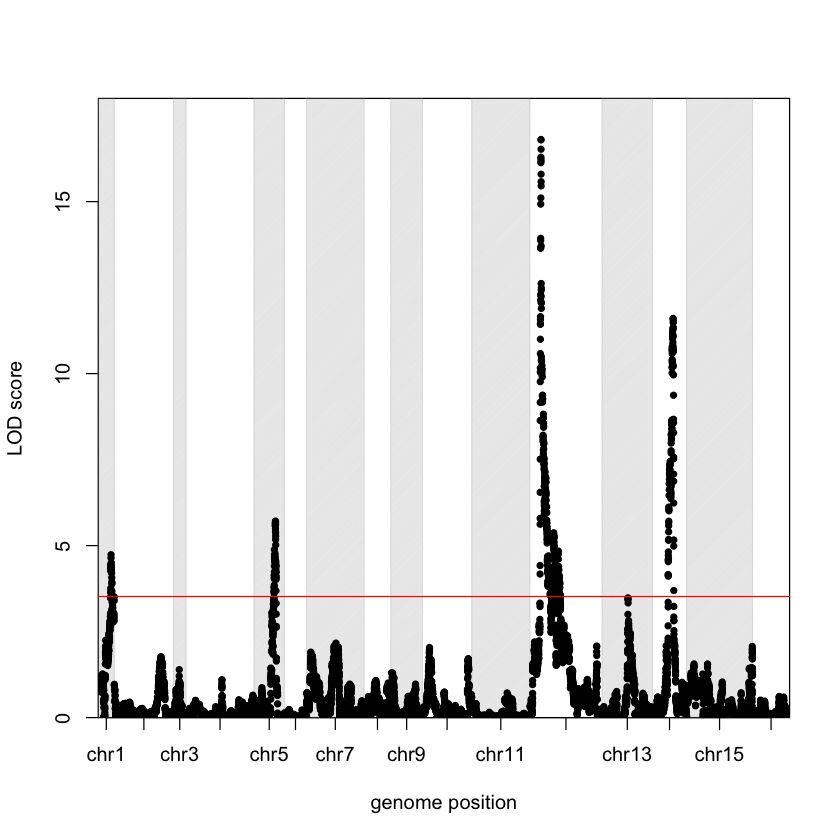

In [24]:
######did the QTL mapping with the residuals
######preparation
library(gdata)

get.LOD.by.COR = function(n.pheno, pheno, gdata) {
  # Lynch and Walsh p. 454
  return( (-n.pheno*log(1-cor(pheno, gdata, use = 'pairwise.complete.obs')^2))/(2*log(10)) )  }


get.LOD.by.COR.rank = function(n.pheno, pheno, gdata) {
  # Lynch and Walsh p. 454
  return( (-n.pheno*log(1-cor(pheno, gdata, use = 'pairwise.complete.obs', method = 'spearman')^2,))/(2*log(10)) )  }


base.dir = '~/Dropbox/MutationRate/20160117_1000segregant/'
#unique chromosomes in order
unique.chrs = c(paste0('chr', as.roman(1:16)), 'chrMito')

######loading genome info
#genotype data -1  = BY, +1  = RM
load(paste0(base.dir, '1000BYxRM_with_names.RData'))

######match genome with pheno (residuals here)
#pheno_input_matrix = pheno.data
#geno_matrix = BYxRM_orig

match_pheno_and_geno = function(pheno_input_matrix, geno_matrix) {
  BYxRM_strain_name = do.call('rbind',strsplit(rownames(geno_matrix), ':'))[,1]
  sname = (do.call('rbind', strsplit(colnames(pheno_input_matrix), '-'))[,1])
  
  pheno_input_matrix = pheno_input_matrix[,-which(is.na(match(sname,BYxRM_strain_name)))]
  sname = (do.call('rbind', strsplit(names(pheno_input_matrix), '-'))[,1])
  gdata = geno_matrix[match(sname,BYxRM_strain_name),]
  return(list(pheno = pheno_input_matrix, gdata = gdata))
}

pg = match_pheno_and_geno(residu, BYxRM_orig)

p = t(pg$pheno)
#p[,1][p[,1]>1000] = NA

#removes non-informative markers
g = pg$gdata[,-which(duplicated(pg$gdata, MARGIN = 2))]
#n = apply(p, 2, function(x) sum(!is.na(x)))
pp = apply(p,2,as.numeric)
n = length(pp)

######QTL mapping
LODs = get.LOD.by.COR(n, pp,g)

##make the x axis as the genome postion
mr_ind = match(colnames(LODs), colnames(BYxRM_orig))

par(xaxs = "i",yaxs = "i")
plot(LODs[1,]~mr_ind,xlab = 'genome position',ylab = 'LOD score',xlim = c(0,28220),ylim = c(0,18),xaxt = "n",pch = 20,type = "n")

#calculate the middle position of each chr (mean of starting and ending positions)
v0 = c(0,647,3066,3577,6356,7594,8499,10846,11942,13229,15244,17614,20565,22622,24013,26707,28220)

#defines position of tick marks
v1 = c()
for (k in 1:(length(v0)-1)){
  v1[k] = mean(c(v0[k],v0[k+1]))
}

#defines labels of tick marks
v2 = paste0("chr",c(1:16))
axis(side = 1,at = v1,labels = v2)

######add shade background to the figure
# set alpha  =  80 so it's relatively transparent
color <- rgb(190, 190, 190, alpha = 80, maxColorValue = 255)

chrpos = c(-2,647,3066,3577,6356,7594,8499,10846,11942,13229,15244,17614,20565,22622,24013,26707)
for (p in c(1,3,5,7,9,11,13,15)){
  rect(chrpos[p],-2,chrpos[p+1],20,density = 100,col = color)
}

points(LODs[1,]~mr_ind,pch = 20)
##this 3.52 was calculated from the 1000 permutation (code attached below)
abline(h = 3.520,col = "red") 

In [ ]:
#1000 permutation for LODs
permu=matrix(NA,nrow = 1000,ncol=2)
for (j in 1:1000){
  print(j)
  this_p = pp[sample(1:length(pp))]
  this_n=length(this_p)
  #this_n = apply(this_p, 2, function(x) sum(!is.na(x)))
  middle=get.LOD.by.COR(this_n, this_p, g)
  #middle=get.LOD.by.COR.rank(this_n, this_p, g)
  permu[j,]=apply(middle,1,max)
}

maxquan=apply(permu,2,quantile,0.95)
abline(h=maxquan[1],col='red')
save(maxquan,file='~/Desktop/maxquan_residual.LODs')